In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
import torchmetrics
torch.__version__

'2.3.0+cu121'

In [2]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
import zipfile, requests
from pathlib import Path

data_path=Path('data/')
image_path=data_path/'bone_break'

if image_path.is_dir():
    print(f"{image_path} directory exists")
else:
    image_path.mkdir(parents=True,exist_ok=True)
    with zipfile.ZipFile(data_path/'Bone Break Classification.zip','r') as zip_ref:
        zip_ref.extractall(image_path)

    

data\bone_break directory exists


In [4]:
import os
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir("data/Bone Break Classification")

There are 10 directories and 0 images in 'data/Bone Break Classification'.
There are 2 directories and 0 images in 'data/Bone Break Classification\Avulsion fracture'.
There are 0 directories and 14 images in 'data/Bone Break Classification\Avulsion fracture\Test'.
There are 0 directories and 109 images in 'data/Bone Break Classification\Avulsion fracture\Train'.
There are 2 directories and 0 images in 'data/Bone Break Classification\Comminuted fracture'.
There are 0 directories and 14 images in 'data/Bone Break Classification\Comminuted fracture\Test'.
There are 0 directories and 134 images in 'data/Bone Break Classification\Comminuted fracture\Train'.
There are 2 directories and 0 images in 'data/Bone Break Classification\Fracture Dislocation'.
There are 0 directories and 19 images in 'data/Bone Break Classification\Fracture Dislocation\Test'.
There are 0 directories and 137 images in 'data/Bone Break Classification\Fracture Dislocation\Train'.
There are 2 directories and 0 images in 

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
data_transform=transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5), #p = probability of flip
    transforms.ToTensor(),
])


Random image path: data\bone_break\train\Avulsion fracture\lightbox_1822d4007d9b11eab7338708af0fabaf-IMG_20191029_122622-2-_png.rf.90495f17b148a38bbd74de2818c6b36b.jpg
Image class: Avulsion fracture
Image height: 506
Image width: 371


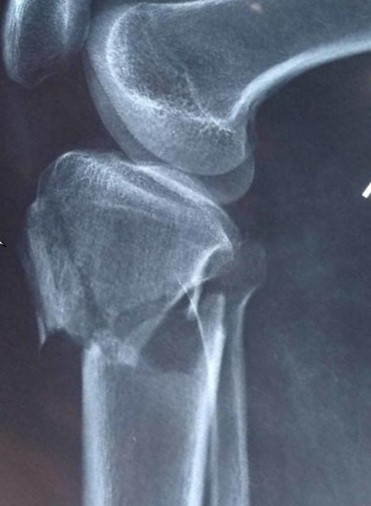

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

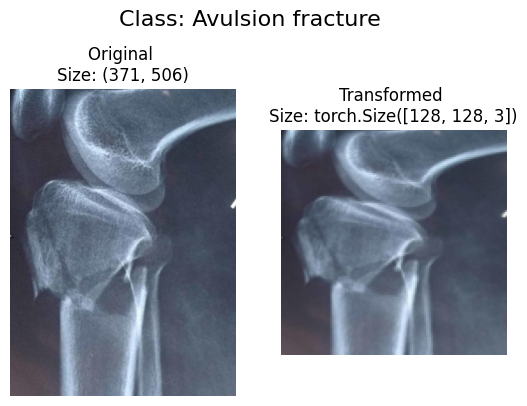

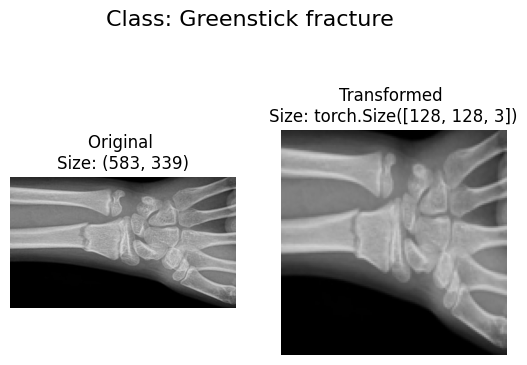

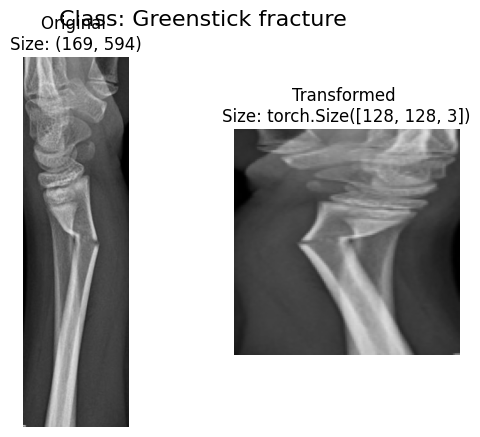

In [9]:
import random
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [10]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/bone_break/train'), WindowsPath('data/bone_break/test'))

In [11]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=test_dir,transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 989
    Root location: data\bone_break\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 140
    Root location: data\bone_break\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'Avulsion fracture': 0,
 'Comminuted fracture': 1,
 'Fracture Dislocation': 2,
 'Greenstick fracture': 3,
 'Hairline Fracture': 4,
 'Impacted fracture': 5,
 'Longitudinal fracture': 6,
 'Oblique fracture': 7,
 'Pathological fracture': 8,
 'Spiral Fracture': 9}

In [14]:
# Check the lengths
len(train_data), len(test_data)

(989, 140)

In [15]:
img, label = train_data[0][0], train_data[0][1]
# print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 128, 128])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [16]:
from torch.utils.data import DataLoader

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=8,
                            num_workers=os.cpu_count(),
                            shuffle=True)

test_dataloader=DataLoader(dataset=test_data, batch_size=8, num_workers=1,shuffle=False)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x160377f36a0>,
 <torch.utils.data.dataloader.DataLoader at 0x16035701940>)

In [17]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([8, 3, 128, 128]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


## Other way to load dataset

In [18]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [19]:
target_directory=train_dir
print(train_dir)
class_names_found=sorted([entry.name for entry in list(os.scandir(train_dir))])
print(f"Class names found: {class_names_found}")

data\bone_break\train
Class names found: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [20]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str,int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx
    
      

In [21]:
find_classes(train_dir)

(['Avulsion fracture',
  'Comminuted fracture',
  'Fracture Dislocation',
  'Greenstick fracture',
  'Hairline Fracture',
  'Impacted fracture',
  'Longitudinal fracture',
  'Oblique fracture',
  'Pathological fracture',
  'Spiral Fracture'],
 {'Avulsion fracture': 0,
  'Comminuted fracture': 1,
  'Fracture Dislocation': 2,
  'Greenstick fracture': 3,
  'Hairline Fracture': 4,
  'Impacted fracture': 5,
  'Longitudinal fracture': 6,
  'Oblique fracture': 7,
  'Pathological fracture': 8,
  'Spiral Fracture': 9})

1.Subclass torch.utils.data.Dataset.

2.Initialize our subclass with a targ_dir parameter (the target data directory) and transform parameter (so we have the option to transform our data if needed).

3.Create several attributes for paths (the paths of our target images), transform (the transforms we might like to use, this can be None), classes and class_to_idx (from our find_classes() function).

4.Create a function to load images from file and return them, this could be using PIL or torchvision.io (for input/output of vision data).

5.Overwrite the __len__ method of torch.utils.data.Dataset to return the number of samples in the Dataset, this is recommended but not required. This is so you can call len(Dataset).

6.Overwrite the __getitem__ method of torch.utils.data.Dataset to return a single sample from the Dataset, this is required.

In [22]:
from torch.utils.data import Dataset
import pathlib

class ImageFolderCustom(Dataset):
    def __init__(self,targ_dir:str ,transform=None) ->None:
        self.paths=list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform=transform
        self.classes, self.class_to_idx = find_classes(targ_dir)
        
    def load_image(self, index:int) -> Image.Image:
        image_path=self.paths[index]
        return Image.open(image_path)
    
    def __len__(self) ->int :
        return len(self.paths)
    
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        img=self.load_image(index)
        class_name=self.paths[index].parent.name
        # expects path in data_folder/class_name/image.jpeg
        class_idx=self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(img),class_idx
        
        return img,class_idx
        

In [23]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [24]:
train_data_custom= ImageFolderCustom(targ_dir=train_dir,transform=train_transforms)

test_data_custom= ImageFolderCustom(targ_dir=test_dir,transform=test_transforms)

train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x1603793cb50>,
 <__main__.ImageFolderCustom at 0x1603793c0d0>)

In [25]:
len(train_data_custom), len(test_data_custom)

(989, 140)

In [26]:
train_data_custom.classes, train_data_custom.class_to_idx

(['Avulsion fracture',
  'Comminuted fracture',
  'Fracture Dislocation',
  'Greenstick fracture',
  'Hairline Fracture',
  'Impacted fracture',
  'Longitudinal fracture',
  'Oblique fracture',
  'Pathological fracture',
  'Spiral Fracture'],
 {'Avulsion fracture': 0,
  'Comminuted fracture': 1,
  'Fracture Dislocation': 2,
  'Greenstick fracture': 3,
  'Hairline Fracture': 4,
  'Impacted fracture': 5,
  'Longitudinal fracture': 6,
  'Oblique fracture': 7,
  'Pathological fracture': 8,
  'Spiral Fracture': 9})

In [27]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [28]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

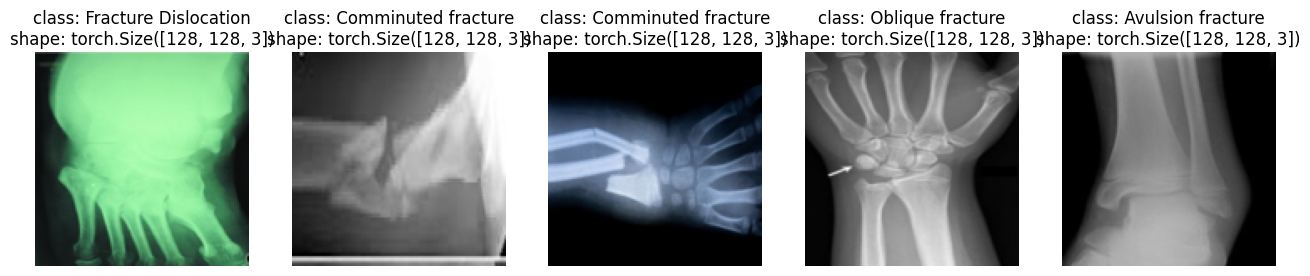

In [29]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


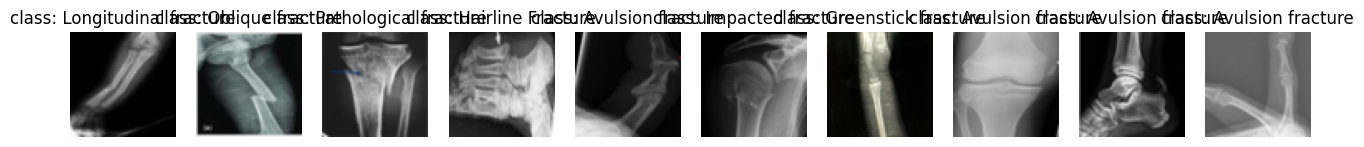

In [30]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

## Model training

In [31]:
from torch.utils.data import DataLoader

train_dataloader_custom=DataLoader(dataset=train_data_custom,batch_size=8,num_workers=0,shuffle=True)

test_dataloader_custom=DataLoader(test_data_custom,batch_size=8,shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x1603793c550>,
 <torch.utils.data.dataloader.DataLoader at 0x1603793cb20>)

In [32]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([8, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([8])


In [39]:
from torchvision import transforms

train_transforms=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), #how intense *study more
    transforms.ToTensor(),
])

test_transforms=transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

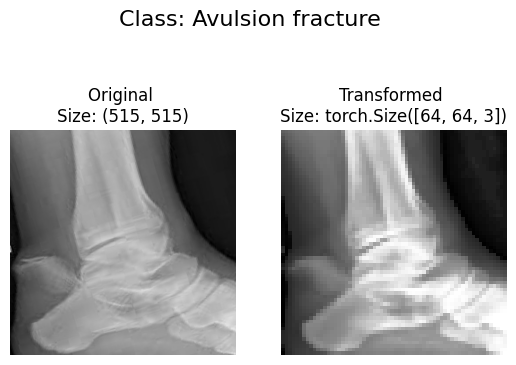

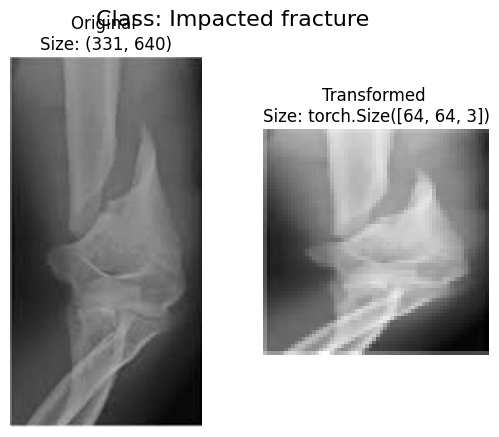

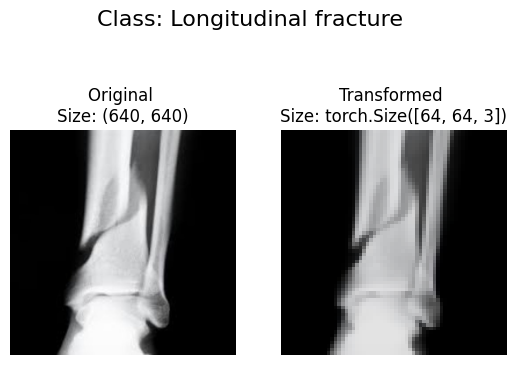

In [40]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

In [41]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,transform=train_transforms)
test_data=datasets.ImageFolder(root=test_dir, transform=test_transforms)


In [42]:
from torch.utils.data import DataLoader

BATCH_SIZE=16
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKERS)

test_dataloader=DataLoader(test_data,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS)



In [58]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int) -> None:
        super().__init__()
        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
        )
        
        self.conv_block2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16, out_features=output_shape)
        )
        
    def forward(self,x:torch.Tensor):
        x=self.conv_block1(x)
        # print(x.shape)
        x=self.conv_block2(x)
        # print(x.shape)
        x=self.classifier(x)
        # print(x.shape)
        return x
        #? return self.classifier(self.conv_block_2(self.conv_block_1(x)))
        #* <- leverage the benefits of operator fusion

Note: One of the ways to speed up deep learning models computing on a GPU is to leverage operator fusion.

This means in the forward() method in our model above, instead of calling a layer block and reassigning x every time, we call each block in succession (see the final line of the forward() method in the model above for an example).

This saves the time spent reassigning x (memory heavy) and focuses on only computing on x

In [44]:
torch.manual_seed(42)
model=TinyVGG(input_shape=3,hidden_units=10,output_shape=len(train_data.classes)).to(device)

model

TinyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=10, bias=True)
  )
)

In [46]:
img_batch,label_batch=next(iter(train_dataloader))

img_single,label_single=img_batch[0].unsqueeze(dim=0),label_batch[0]
print(img_single.shape)

model.eval()
with torch.inference_mode():
    pred=model(img_single.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

torch.Size([1, 3, 64, 64])
torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 10])
Output logits:
tensor([[ 0.0497,  0.0540,  0.0263, -0.0462, -0.0445,  0.0314, -0.0744,  0.0855,
         -0.0285,  0.0628]], device='cuda:0')

Output prediction probabilities:
tensor([[0.1037, 0.1042, 0.1013, 0.0943, 0.0944, 0.1019, 0.0916, 0.1075, 0.0959,
         0.1051]], device='cuda:0')

Output prediction label:
tensor([7], device='cuda:0')

Actual label:
5


In [48]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

torch.Size([1, 10, 32, 32])
torch.Size([1, 10, 16, 16])
torch.Size([1, 10])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 10]                   --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [56]:
def train_step(model:torch.nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer):
    model.train()
    
    train_loss,train_acc=0,0
    
    for batch, (X,y) in enumerate(dataloader):
        X,y=X.to(device) , y.to(device)
        
        y_pred=model(X)
        
        loss=loss_fn(y_pred,y)
        
        train_loss+=loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        y_pred_class=torch.argmax(torch.softmax(y_pred,dim=1) , dim=1)
        train_acc+=(y_pred_class==y).sum().item()/len(y_pred)
        
    train_loss/=len(dataloader)
    train_acc/=len(dataloader)
    return train_loss,train_acc


In [52]:
def test_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module):
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y=X.to(device), y.to(device)
            test_pred=model(X)
            
            loss=loss_fn(test_pred,y)
            test_loss+=loss.item()
            
            test_pred_class=torch.argmax(torch.softmax(test_pred,dim=1),dim=1)
            test_acc+= ((test_pred_class == y).sum().item()/len(test_pred))
            
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [54]:

from tqdm.auto import tqdm

def train(model:torch.nn.Module, train_dataloader:torch.utils.data.DataLoader, test_dataloader:torch.utils.data.DataLoader, optimizer:torch.optim.Optimizer, loss_fn:torch.nn.Module, epochs:int=5):
    
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model=model,dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer)
        
        test_loss,test_acc=test_step(model,dataloader=test_dataloader,loss_fn=loss_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results
        

In [63]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.2971 | train_acc: 0.1352 | test_loss: 2.3017 | test_acc: 0.0972
Epoch: 2 | train_loss: 2.2771 | train_acc: 0.1355 | test_loss: 2.3061 | test_acc: 0.0972
Epoch: 3 | train_loss: 2.2733 | train_acc: 0.1210 | test_loss: 2.3098 | test_acc: 0.0972
Epoch: 4 | train_loss: 2.2733 | train_acc: 0.1396 | test_loss: 2.3095 | test_acc: 0.1319
Epoch: 5 | train_loss: 2.2734 | train_acc: 0.1386 | test_loss: 2.3132 | test_acc: 0.1319
Total training time: 521.610 seconds


In [60]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [65]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

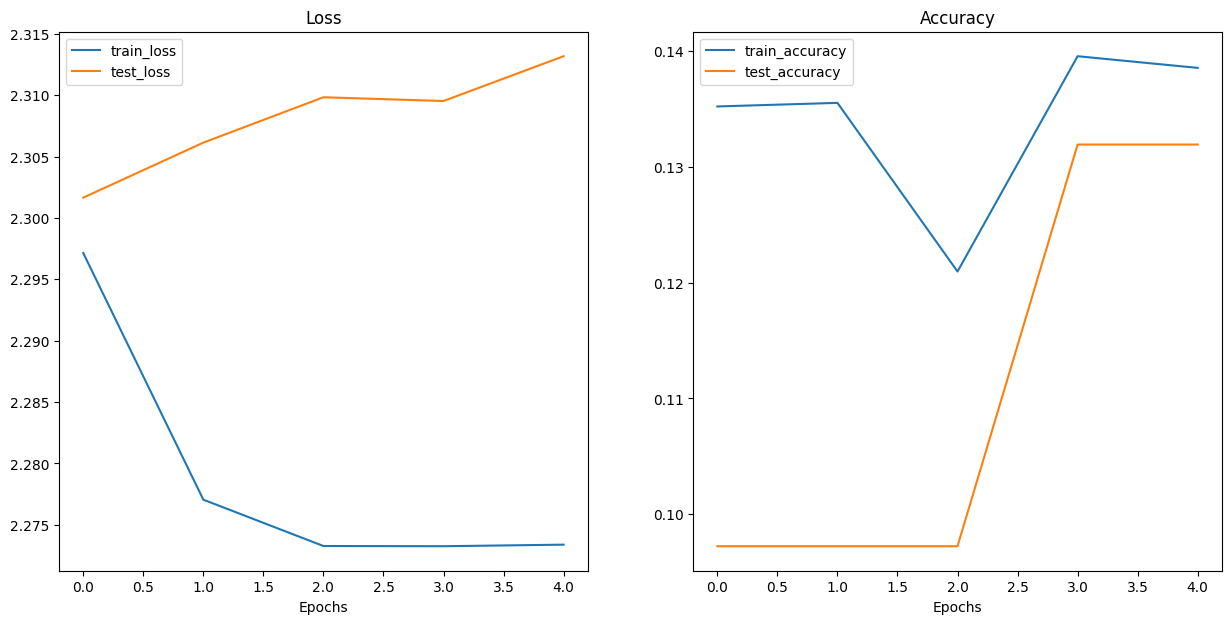

In [66]:
plot_loss_curves(model_0_results)

In [72]:
import torchvision
custom_image_uint8=torchvision.io.read_image('data/bone_break/test/Avulsion fracture/1-s2-0-S0899707114002836-gr2_jpg.rf.bb8ed4dee892edbb760f6ce687d74ba5.jpg')

custom_image_float32=custom_image_uint8.type(torch.float32)/255

# print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image shape: torch.Size([3, 526, 351])

Custom image dtype: torch.uint8


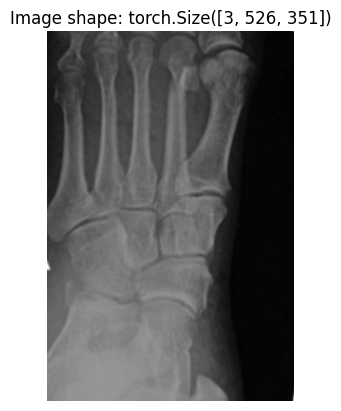

In [76]:
# Plot custom image
plt.imshow(custom_image_float32.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_float32.shape}")
plt.axis(False);

In [81]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image_float32)

# Print out original shape and new shape
print(f"Original shape: {custom_image_float32.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 526, 351])
New shape: torch.Size([3, 64, 64])


In [83]:
custom_image=custom_image_transformed.unsqueeze(dim=0)
custom_image.shape

torch.Size([1, 3, 64, 64])

In [85]:
model_0.eval()
with torch.inference_mode():
    custom_image_pred =model_0(custom_image.to(device))

In [86]:
custom_image_pred

tensor([[ 0.0991,  0.3156,  0.3412,  0.0763,  0.0051, -0.2790, -0.3981, -0.3618,
          0.1658, -0.3039]], device='cuda:0')

In [87]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.0991,  0.3156,  0.3412,  0.0763,  0.0051, -0.2790, -0.3981, -0.3618,
          0.1658, -0.3039]], device='cuda:0')
Prediction probabilities: tensor([[0.1103, 0.1370, 0.1405, 0.1078, 0.1004, 0.0756, 0.0671, 0.0696, 0.1179,
         0.0737]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')


In [88]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'Fracture Dislocation'

In [89]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);